In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import seaborn as sns 
import matplotlib.pyplot as plt
import keras as k
from sklearn.model_selection import train_test_split
import sklearn as sk 

## Import & View Data

In [2]:
df = pd.read_csv('trainingdata.csv')
df

# Outside of "IDs" (game_id, home_team, away_team), the data contains 476 instances with 13 features.

,game_id,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP
0,game_2023_94,TUC,ALB,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53
1,game_2023_341,MOB,ALB,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56
2,game_2023_442,CHM,ALB,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52
3,game_2023_50,SAS,ALB,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49
4,game_2023_389,FOR,ALB,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,game_2023_81,TUC,WIC,2,1,2.72,0.38,16,8,8,2,0,0,0,0,0.33
472,game_2023_36,DOV,WIC,0,2,1.11,1.34,9,13,7,4,0,0,0,0,0.31
473,game_2023_269,SFS,WIC,1,1,2.84,0.30,26,2,8,6,0,0,0,0,0.54
474,game_2023_298,ALB,WIC,2,3,2.61,2.09,12,17,7,4,0,0,0,0,0.43


In [3]:
def analyze(data):
    
  # View features in the data
  print("Features")
  print(data.columns.values)
  print("-" * 70)
    
  # View the details the features in the data (data type, non-null count, memory usage etc.)
  print("Feature Details")
  print(data.info())
  print("-" * 70)

  #View the mean, standard deviation, minimum and maximum values of the features
  print("Feature Summary")
  print(data.describe())
  print("-" * 70)


analyze(df)

Features
['game_id' 'HomeTeam' 'AwayTeam' 'HomeScore' 'AwayScore' 'Home_xG'
 'Away_xG' 'Home_shots' 'Away_shots' 'Home_corner' 'Away_corner'
 'Home_PK_Goal' 'Away_PK_Goal' 'Home_PK_shots' 'Away_PK_shots' 'Home_ToP']
----------------------------------------------------------------------
Feature Details
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        476 non-null    object 
 1   HomeTeam       476 non-null    object 
 2   AwayTeam       476 non-null    object 
 3   HomeScore      476 non-null    int64  
 4   AwayScore      476 non-null    int64  
 5   Home_xG        476 non-null    float64
 6   Away_xG        476 non-null    float64
 7   Home_shots     476 non-null    int64  
 8   Away_shots     476 non-null    int64  
 9   Home_corner    476 non-null    int64  
 10  Away_corner    476 non-null    int64  
 11  Home_PK_Goal   

In [4]:
features = ['HomeScore', 'AwayScore', 'Home_xG',
 'Away_xG', 'Home_shots', 'Away_shots', 'Home_corner', 'Away_corner',
 'Home_PK_Goal', 'Away_PK_Goal', 'Home_PK_shots', 'Away_PK_shots', 'Home_ToP']


def plot(df, features):
    
    for i in features:
        sns.scatterplot(data=df, x= i, y='prev_results')
        plt.show()

In [5]:
training_features = df.drop(['game_id', 'HomeTeam', 'AwayTeam'], axis=1)

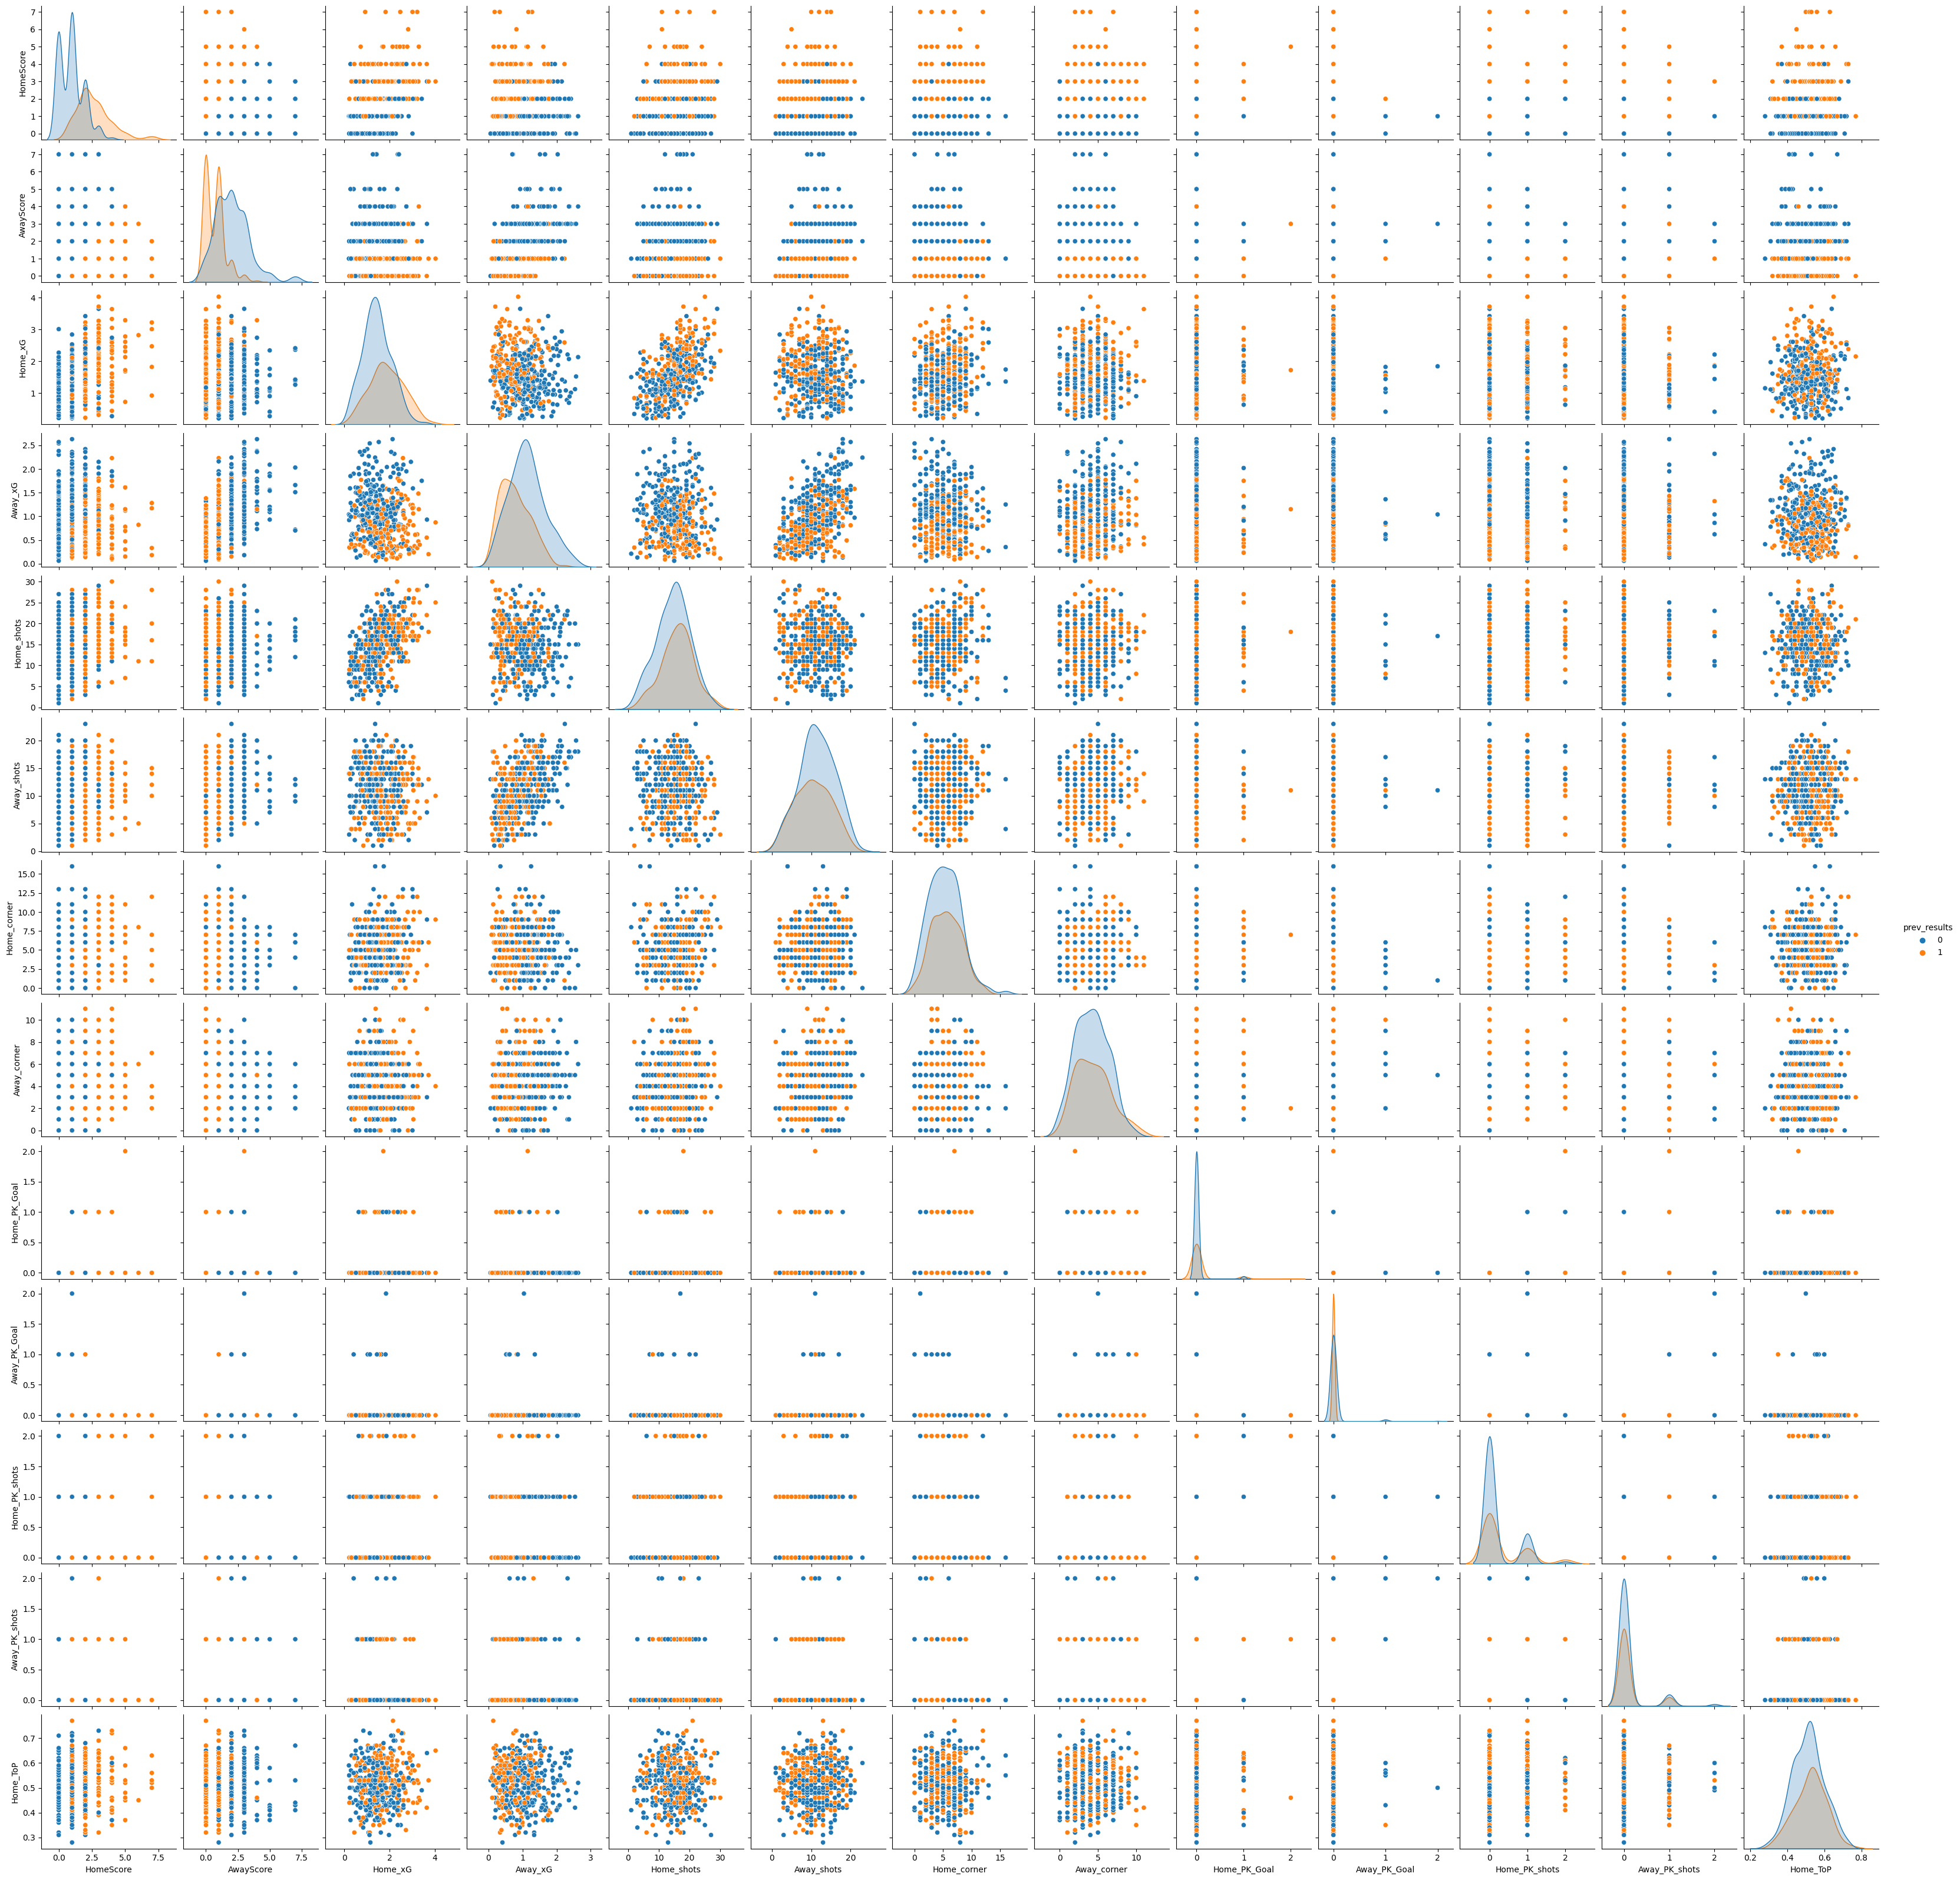

In [6]:
#Create sns pairplot and "prev results binary column" to see if there are any patterns in the data

#Binary feature labels based off the scores

def prev_results(row):
    if row['HomeScore'] > row['AwayScore']:
        return 1
    else:
        return 0
    
training_features['prev_results'] = training_features.apply(lambda row: prev_results(row), axis=1)

def pairplot(df):
    sns.pairplot(df, hue='prev_results')
    plt.show()

pairplot(training_features)

## Feature Engineering (main features for the "baseline" model)
- Here we create 4 new features (2 per side) --> Attempts at getting a higher correlation than original features
    - This will prove successful (with the r of these features having better linear/simple relations with the prev_results supervised label)

In [7]:
training_features['HomeConversion'] = training_features['HomeScore'] / training_features['Home_xG']
training_features['AwayConversion'] = training_features['AwayScore'] / training_features['Away_xG']
training_features['HomeAccuracy'] = training_features['HomeScore'] / training_features['Home_shots']
training_features['AwayAccuracy'] = training_features['AwayScore'] / training_features['Away_shots']
training_features['GoalDifference'] = training_features['HomeScore'] - training_features['AwayScore']

OG_training_features = training_features.copy()

In [8]:
correlation = training_features.corr()
corr = correlation['prev_results'].sort_values(ascending=False)

corr


prev_results      1.000000
GoalDifference    0.777795
HomeScore         0.612433
HomeAccuracy      0.421621
HomeConversion    0.302462
Home_xG           0.298969
Home_shots        0.131280
Home_PK_Goal      0.127288
Home_PK_shots     0.119119
Home_ToP          0.067499
Home_corner       0.055772
Away_corner       0.043447
Away_PK_shots     0.004993
Away_PK_Goal     -0.071373
Away_shots       -0.112393
AwayConversion   -0.273310
Away_xG          -0.324928
AwayAccuracy     -0.415982
AwayScore        -0.502372
Name: prev_results, dtype: float64

In [9]:
training_features = training_features.drop(['Home_PK_Goal', 'Away_PK_Goal', 'Home_PK_shots', 'Away_PK_shots', 'GoalDifference', ], axis=1)
training_features.head()

,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_ToP,prev_results,HomeConversion,AwayConversion,HomeAccuracy,AwayAccuracy
0,1,3,2.52,2.00,13,15,3,4,0.53,0,0.396825,1.500000,0.076923,0.200000
1,3,1,0.46,0.99,11,8,3,6,0.56,1,6.521739,1.010101,0.272727,0.125000
2,0,1,1.62,1.16,16,13,1,7,0.52,0,0.000000,0.862069,0.000000,0.076923
3,2,1,1.53,0.55,20,2,6,1,0.49,1,1.307190,1.818182,0.100000,0.500000
4,0,2,2.15,1.13,18,13,2,0,0.71,0,0.000000,1.769912,0.000000,0.153846


In [10]:
training_features.shape

(476, 14)

## Create AutoEncoder Neural Network 
### (Unsupervised Binary Classification)

In [11]:
from keras.models import Model
from keras.layers import Input, Dense

# Declare random seed for reproducibility

np.random.seed(42)
# Define the number of features
n_features = training_features.shape[1]

# Define the encoder layers
input_layer = Input(shape=(n_features,))
encoder_layer_1 = Dense(50, activation='relu')(input_layer)
encoder_layer_2 = Dense(30, activation='relu')(encoder_layer_1)

# Define the bottleneck layer
bottleneck_layer = Dense(10, activation='relu')(encoder_layer_2)

# Define the decoder layers
decoder_layer_1 = Dense(30, activation='relu')(bottleneck_layer)
decoder_layer_2 = Dense(50, activation='relu')(decoder_layer_1)

# Define the output layer
output_layer = Dense(n_features, activation='linear')(decoder_layer_2)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.summary()

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder model
autoencoder.fit(training_features, training_features, epochs=500, batch_size=32, shuffle=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 50)                750       
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 30)                330       
                                                                 
 dense_4 (Dense)             (None, 50)                1550      
                                                                 
 dense_5 (Dense)             (None, 14)                714   

## Create Artificial Data Engineering for the Group/K.O Rounds
- Use a metric (in this case an average) based on an individual team count and add that for its specific feature
- Then we add up these averages between the Home and Away teams

In [12]:
OG_training_features.head()

,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,prev_results,HomeConversion,AwayConversion,HomeAccuracy,AwayAccuracy,GoalDifference
0,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53,0,0.396825,1.500000,0.076923,0.200000,-2
1,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56,1,6.521739,1.010101,0.272727,0.125000,2
2,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52,0,0.000000,0.862069,0.000000,0.076923,-1
3,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49,1,1.307190,1.818182,0.100000,0.500000,1
4,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71,0,0.000000,1.769912,0.000000,0.153846,-2


In [13]:
training_features

,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_ToP,prev_results,HomeConversion,AwayConversion,HomeAccuracy,AwayAccuracy
0,1,3,2.52,2.00,13,15,3,4,0.53,0,0.396825,1.500000,0.076923,0.200000
1,3,1,0.46,0.99,11,8,3,6,0.56,1,6.521739,1.010101,0.272727,0.125000
2,0,1,1.62,1.16,16,13,1,7,0.52,0,0.000000,0.862069,0.000000,0.076923
3,2,1,1.53,0.55,20,2,6,1,0.49,1,1.307190,1.818182,0.100000,0.500000
4,0,2,2.15,1.13,18,13,2,0,0.71,0,0.000000,1.769912,0.000000,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2,1,2.72,0.38,16,8,8,2,0.33,1,0.735294,2.631579,0.125000,0.125000
472,0,2,1.11,1.34,9,13,7,4,0.31,0,0.000000,1.492537,0.000000,0.153846
473,1,1,2.84,0.30,26,2,8,6,0.54,0,0.352113,3.333333,0.038462,0.500000
474,2,3,2.61,2.09,12,17,7,4,0.43,0,0.766284,1.435407,0.166667,0.176471


In [14]:
labels = df[['game_id', 'HomeTeam', 'AwayTeam']]
training_features = training_features.reset_index(drop=True)

group_rounds = pd.read_csv('GroupRounds.csv')
KO_rounds = pd.read_csv('KnockoutRounds.csv')
NEW_df = pd.concat([labels, training_features], axis=1)

In [15]:
import numpy as np

numerical_features = ['HomeScore', 'AwayScore', 'Home_xG', 'Away_xG', 'Home_shots', 'Away_shots', 'Home_corner', 'Away_corner', 'Home_ToP', 'prev_results', 
                      'HomeConversion', 'AwayConversion', 'HomeAccuracy', 'AwayAccuracy']

log_transformed_features = []
for feature in numerical_features:
    if np.isinf(np.log1p(NEW_df[feature])).any():
        average_feature = NEW_df[feature].mean()
        log_transformed_feature = np.log1p(NEW_df[feature].replace(-np.inf, average_feature))
    else:
        log_transformed_feature = np.log1p(NEW_df[feature])
    log_transformed_features.append(log_transformed_feature)

df_log_transformed = pd.DataFrame(log_transformed_features).T
df_log_transformed.columns = [f'{feature}_log_transformed' for feature in numerical_features]

df_log_transformed.head()



,HomeScore_log_transformed,AwayScore_log_transformed,Home_xG_log_transformed,Away_xG_log_transformed,Home_shots_log_transformed,Away_shots_log_transformed,Home_corner_log_transformed,Away_corner_log_transformed,Home_ToP_log_transformed,prev_results_log_transformed,HomeConversion_log_transformed,AwayConversion_log_transformed,HomeAccuracy_log_transformed,AwayAccuracy_log_transformed
0,0.693147,1.386294,1.258461,1.098612,2.639057,2.772589,1.386294,1.609438,0.425268,0.000000,0.334202,0.916291,0.074108,0.182322
1,1.386294,0.693147,0.378436,0.688135,2.484907,2.197225,1.386294,1.945910,0.444686,0.693147,2.017797,0.698185,0.241162,0.117783
2,0.000000,0.693147,0.963174,0.770108,2.833213,2.639057,0.693147,2.079442,0.418710,0.000000,0.000000,0.621688,0.000000,0.074108
3,1.098612,0.693147,0.928219,0.438255,3.044522,1.098612,1.945910,0.693147,0.398776,0.693147,0.836030,1.036092,0.095310,0.405465
4,0.000000,1.098612,1.147402,0.756122,2.944439,2.639057,1.098612,0.000000,0.536493,0.000000,0.000000,1.018815,0.000000,0.143101


In [16]:
df_log_transformed = df_log_transformed.reset_index(drop=True)

log_df = pd.concat([labels, df_log_transformed], axis=1)

In [17]:
log_df.head()

print(log_df.shape)

(476, 17)


In [18]:
# Create an empty DataFrame to store all the data
all_away_games_df = pd.DataFrame()

# Iterate through the instances of log_df
for i in range(0, len(log_df), 17):
    # Get the Away Team name for the current set of instances
    away_team = log_df.loc[i, 'AwayTeam']
    
    # Create a DataFrame for the current Away Team
    away_games_df = pd.DataFrame()
    
    # Iterate through the next 17 instances and add the data to the DataFrame
    for j in range(i, i+17):
        # Add the data to the DataFrame
        away_games_df = pd.concat([away_games_df, log_df.loc[j:j]], ignore_index=True)
    
    # Add the Away Team name as a new column
    away_games_df['AwayTeam'] = away_team
    
    # Concatenate the current DataFrame with the main DataFrame
    all_away_games_df = pd.concat([all_away_games_df, away_games_df], ignore_index=True)

# Now all_away_games_df contains the data for all away teams
# You can calculate the average of each feature for each team like this:
# Select only the numeric columns
numeric_columns = all_away_games_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate the mean of the numeric columns
away_games_avg = all_away_games_df.groupby('AwayTeam')[numeric_columns].mean()
away_games_avg.reset_index(inplace=True)

away_games_avg = away_games_avg.drop(columns=away_games_avg.filter(like='Home').columns)

In [19]:
away_games_avg.head()

away_games_avg = away_games_avg.rename(columns={'AwayTeam': 'Team'})
transformed_features = away_games_avg.copy()

transformed_features.head()

,Team,AwayScore_log_transformed,Away_xG_log_transformed,Away_shots_log_transformed,Away_corner_log_transformed,prev_results_log_transformed,AwayConversion_log_transformed,AwayAccuracy_log_transformed
0,ALB,0.958573,0.803611,2.534418,1.568802,0.285414,0.836510,0.149320
1,ANC,0.914003,0.674043,2.480376,1.529218,0.203867,0.836578,0.158424
2,AUG,0.846247,0.717250,2.512839,1.528158,0.163093,0.836246,0.124283
3,BAK,0.703208,0.622428,2.262203,1.620094,0.285414,0.665237,0.127147
4,BOI,0.910871,0.726670,2.500324,1.339872,0.244640,0.812112,0.139238


In [20]:
# Iterate through the instances of group_rounds
for row, column in group_rounds.iterrows():
    home = column['HomeTeam']
    away = column['AwayTeam']

    # Check if the team is a home team or an away team before getting the data
    for instance, team in transformed_features.iterrows():

        if home == team['Team']:
            # Concatenate home team features to the corresponding row in group_rounds
            for feature in transformed_features.columns.drop('Team'):
                group_rounds.loc[row, f'Home_{feature}'] = team[feature]

        if away == team['Team']:
            # Concatenate away team features to the corresponding row in group_rounds
            for feature in transformed_features.columns.drop('Team'):
                group_rounds.loc[row, f'Away_{feature}'] = team[feature]

# Remove unnecessary columns
columns_to_remove = ['game_id', 'HomeTeam', 'AwayTeam', 'Team']
group_rounds = group_rounds.drop(columns=columns_to_remove, errors='ignore')

# Display the modified group_rounds DataFrame
print(group_rounds)

    Home_AwayScore_log_transformed  Home_Away_xG_log_transformed   
0                         0.914003                      0.674043  \
1                         0.941650                      0.713807   
2                         0.618529                      0.508812   
3                         0.941650                      0.713807   
4                         0.914003                      0.674043   
5                         0.788551                      0.714354   
6                         0.975495                      0.743096   
7                         0.757107                      0.580475   
8                         0.607804                      0.526969   
9                         0.757107                      0.580475   
10                        0.975495                      0.743096   
11                        0.707004                      0.649692   
12                        0.923997                      0.683198   
13                        0.930925              

In [21]:
print(group_rounds.head())
print(group_rounds.shape)

   Home_AwayScore_log_transformed  Home_Away_xG_log_transformed   
0                        0.914003                      0.674043  \
1                        0.941650                      0.713807   
2                        0.618529                      0.508812   
3                        0.941650                      0.713807   
4                        0.914003                      0.674043   

   Home_Away_shots_log_transformed  Home_Away_corner_log_transformed   
0                         2.480376                          1.529218  \
1                         2.615730                          1.543739   
2                         2.295570                          1.611757   
3                         2.615730                          1.543739   
4                         2.480376                          1.529218   

   Home_prev_results_log_transformed  Home_AwayConversion_log_transformed   
0                           0.203867                             0.836578  \
1         

## Test the AutoEncoder model on our data
- Due to the way some of the data is arranged, we would have to standardize it to prevent outliers from appearing in optimization
- We will utilize simple Standard Scaling + Reconstruction Error to determine the results (with the latter utilizing a MSE metric that works inversely to the orignal model to extract results)

In [22]:
from sklearn.preprocessing import StandardScaler

# Assume that group_rounds is your DataFrame

# Initialize a scaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
group_rounds_scaled = scaler.fit_transform(group_rounds)

# Now group_rounds_scaled contains the scaled version of your data

In [23]:
# Use the autoencoder to generate the output for your data
Group_output = autoencoder.predict(group_rounds_scaled)

# Calculate the reconstruction error as the MSE between the input and output
Group_reconstruction_error = np.mean(np.power(group_rounds_scaled - Group_output, 2), axis=1)

# Choose a threshold for the reconstruction error to classify instances as normal or anomalous
# This threshold could be chosen based on domain knowledge, or you could use a method like the elbow method to choose it
threshold = 0.5

# Make binary predictions based on the reconstruction error
Group_predictions = np.where(Group_reconstruction_error > threshold, 1, 0)

# Define a high error threshold
high_error_threshold = 1.25

# Adjust the predictions based on the reconstruction error
Group_predictions = [1 - prediction if error > high_error_threshold else prediction for prediction, error in zip(Group_predictions, Group_reconstruction_error)]

print('Predictions:', Group_predictions)
print('Reconstruction error:', Group_reconstruction_error)

2/2 [==============================] - 0s 2ms/step
Predictions: [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
Reconstruction error: [0.28334073 1.02275522 1.18571039 0.49227236 1.22572258 1.11436764
 0.68843803 1.03174315 1.63480648 0.37032791 1.03552759 1.26069829
 1.35789438 0.45419376 0.97803353 0.97563923 1.11188768 0.28921226
 0.63347092 1.50790897 0.57016367 1.57380239 0.86105801 0.76632928
 1.14386816 0.29333099 2.30697872 0.42354189 1.24772061 0.79554811
 1.1665565  1.47358273 1.7087458  0.80540803 0.910147   1.73821831
 0.59998487 3.64094241 3.58940107 1.02994785 1.06369062 3.06281709]


In [24]:
# Iterate through the instances of KO_rounds
for row, column in KO_rounds.iterrows():
    teamA = column['TeamA']
    teamB = column['TeamB']

    # Check if the team is a teamA or a teamB before getting the data
    for instance, team in transformed_features.iterrows():

        if teamA == team['Team']:
            # Concatenate teamA features to the corresponding row in KO_rounds
            for feature in transformed_features.columns.drop('Team'):
                KO_rounds.loc[row, f'TeamA_{feature}'] = team[feature]

        if teamB == team['Team']:
            # Concatenate teamB features to the corresponding row in KO_rounds
            for feature in transformed_features.columns.drop('Team'):
                KO_rounds.loc[row, f'TeamB_{feature}'] = team[feature]

# Remove unnecessary columns
# columns_to_remove = ['game_id', 'TeamA', 'TeamB', 'Team']
# KO_rounds = KO_rounds.drop(columns=columns_to_remove, errors='ignore')

#Home win is 1; Away win is 0

In [29]:
import pandas as pd

class Elo:
    def __init__(self, initial_rating=1500, k_factor=32):
        self.initial_rating = initial_rating
        self.k_factor = k_factor
        self.ratings = {}

    def add_team(self, team):
        self.ratings[team] = self.initial_rating

    def expected_score(self, team, opponent):
        team_rating = self.ratings[team]
        opponent_rating = self.ratings[opponent]
        return 1 / (1 + 10 ** ((opponent_rating - team_rating) / 400))

    def update_rating(self, team, opponent, score):
        expected = self.expected_score(team, opponent)
        self.ratings[team] += self.k_factor * (score - expected)

elo = Elo()

# Read the CSV file
OG_ko_rounds = pd.read_csv('KnockoutRounds.csv')

# Extract the unique teams and add them to the system
teams = pd.concat([OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']]).unique()
for team in teams:
    elo.add_team(team)

# Extract the games
games = list(zip(OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']))

# Assume the first team wins each game
# Update ratings based on game outcomes
for game in games:
    team1, team2 = game
    elo.update_rating(team1, team2, 1)  # Assume team1 wins
    elo.update_rating(team2, team1, 0)  # Assume team2 loses

    # Calculate the probability that the first team wins the game
    probability_team1_wins = elo.expected_score(team1, team2)
    print(f'Probability that {team1} won against {team2}:', probability_team1_wins)

Probability that DOV won against OAK: 0.544871027446134
Probability that FOR won against AUG: 0.544871027446134
Probability that DOV won against FOR: 0.544871027446134
Probability that DOV won against AUG: 0.6053466238112014
Probability that OAK won against FOR: 0.5240181843144569
Probability that OAK won against AUG: 0.5834487459731498


In [30]:
import pandas as pd
import trueskill

# Initialize TrueSkill
ts = trueskill.TrueSkill()

# Read the CSV file
OG_ko_rounds = pd.read_csv('KnockoutRounds.csv')

# Extract the unique teams and add them to the system
teams = pd.concat([OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']]).unique()
ratings = {team: ts.create_rating() for team in teams}

# Extract the games
games = list(zip(OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']))

# Assume the first team wins each game
# Update ratings based on game outcomes
for game in games:
    team1, team2 = game
    ratings[team1], ratings[team2] = ts.rate_1vs1(ratings[team1], ratings[team2])

# Print the final ratings
for team, rating in ratings.items():
    print(f'{team}: {rating}')

DOV: trueskill.Rating(mu=34.013, sigma=5.885)
FOR: trueskill.Rating(mu=21.686, sigma=5.480)
OAK: trueskill.Rating(mu=27.563, sigma=5.500)
AUG: trueskill.Rating(mu=17.366, sigma=5.956)


In [33]:
import pandas as pd
import trueskill

from math import sqrt
# Initialize TrueSkill
ts = trueskill.TrueSkill()

# Read the CSV file
OG_ko_rounds = pd.read_csv('KnockoutRounds.csv')

# Extract the unique teams and add them to the system
teams = pd.concat([OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']]).unique()
ratings = {team: ts.create_rating() for team in teams}

# Extract the games
games = list(zip(OG_ko_rounds['TeamA'], OG_ko_rounds['TeamB']))

# Assume the first team wins each game
# Update ratings based on game outcomes
for game in games:
    team1, team2 = game
    ratings[team1], ratings[team2] = ts.rate_1vs1(ratings[team1], ratings[team2])

    # Calculate the win probability for team1
    delta_mu = ratings[team1].mu - ratings[team2].mu
    sum_sigma = sum([ratings[team1].sigma ** 2, ratings[team2].sigma ** 2])
    size = 2
    denom = sqrt(size * (ts.beta * ts.beta) + sum_sigma)
    ts_win_probability = ts.cdf(delta_mu / denom)

    print(f'Probability that {team1} wins against {team2}: {round(ts_win_probability * 100, 2)}%')

Probability that DOV wins against OAK: 77.32%
Probability that FOR wins against AUG: 77.32%
Probability that DOV wins against FOR: 75.59%
Probability that DOV wins against AUG: 91.57%
Probability that OAK wins against FOR: 66.39%
Probability that OAK wins against AUG: 84.55%
